### Import all necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import joblib


### Import the Dataset

In [2]:
ticker_symbol = 'TSLA'
dataset_path = os.path.join('dataset', f'{ticker_symbol}-stock.csv')

tesla_data = pd.read_csv(dataset_path)
tesla_data['Date'] = pd.to_datetime(tesla_data['Date'])
tesla_data.set_index('Date', inplace=True)

### Visualize the Dataset

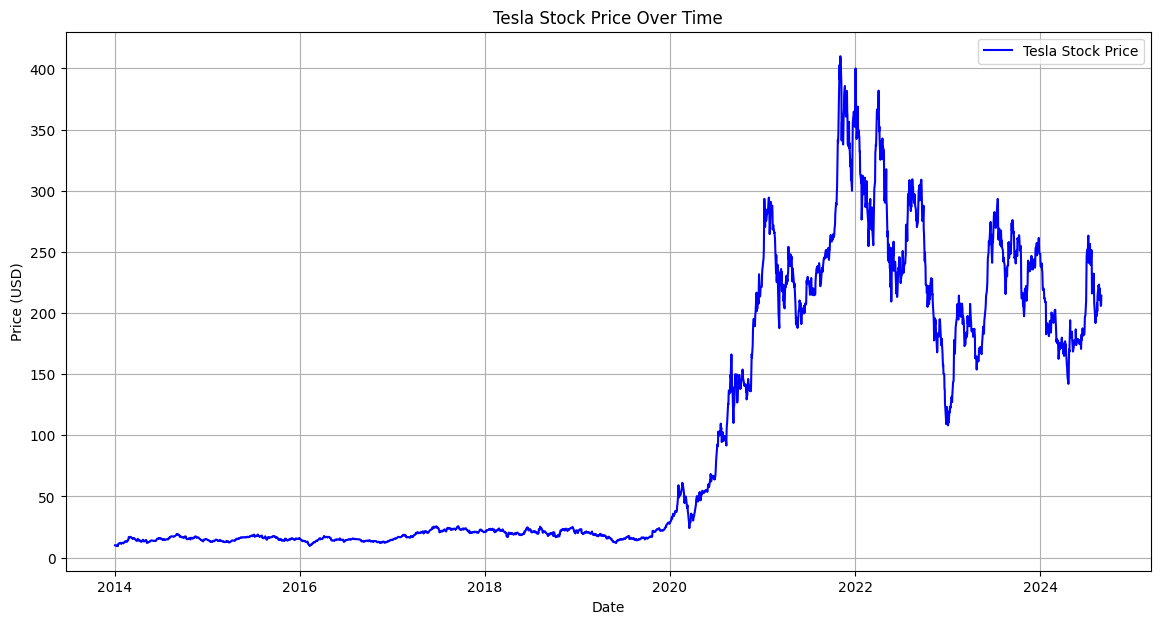

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Plotting the closing price of Tesla stock
plt.figure(figsize=(14, 7))
plt.plot(tesla_data['Close'], label='Tesla Stock Price', color='blue')
plt.title('Tesla Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()

### Taking the first difference as it creates a stationary Time-series.

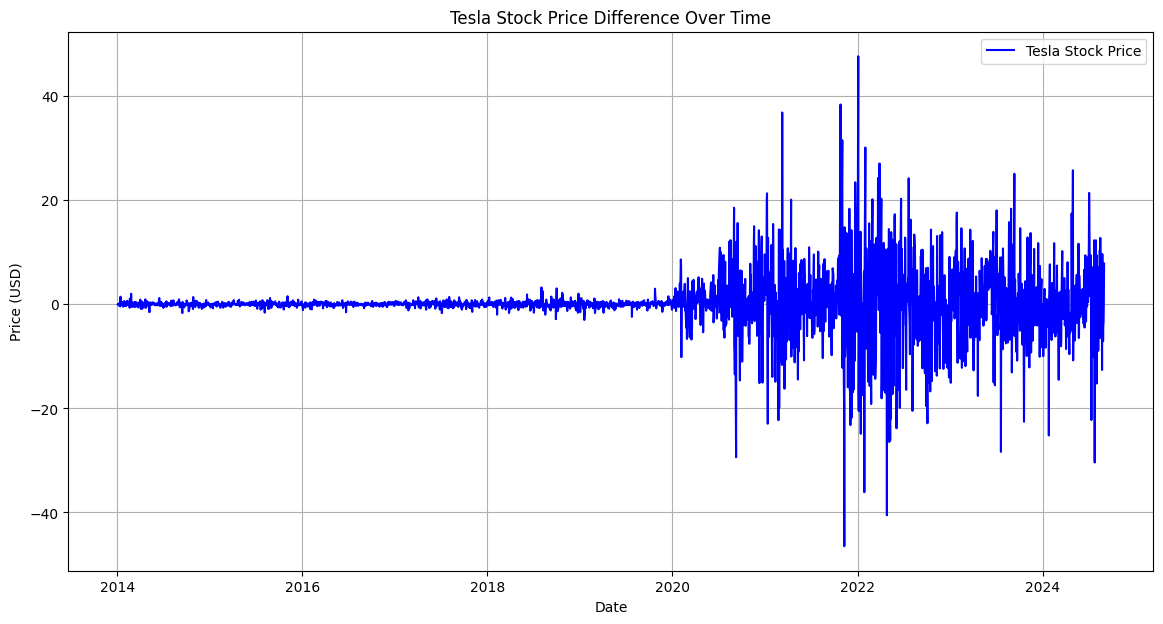

In [4]:
# Differencing
tesla_data['Close_diff'] = tesla_data['Close'].diff()

tesla_data.dropna(inplace=True)

plt.figure(figsize=(14, 7))
plt.plot(tesla_data['Close_diff'], label='Tesla Stock Price', color='blue')
plt.title('Tesla Stock Price Difference Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()

### Training ARIMA Model using the first difference

In [5]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid

#### Splitting the data into training and testing sets

In [6]:
train_size = int(len(tesla_data) * 0.8)
train_data, test_data = tesla_data[:train_size], tesla_data[train_size:]

In [7]:
os.makedirs('split_data_for_arima', exist_ok=True)
train_data_path = os.path.join('split_data_for_arima', 'train.csv')
test_data_path = os.path.join('split_data_for_arima', 'test.csv')

train_data.to_csv(train_data_path, index=True)
test_data.to_csv(test_data_path, index=True)

#### Setting up to check the best ARIMA Model

In [8]:
arima_param_grid = {
    'p' : range(0, 5),
    'd' : [1], # since we are using the first difference only as it makes the series stationary
    'q' : range(0, 5)
}

arima_orders = pdq = [(p, d, q) for p in arima_param_grid['p'] for d in arima_param_grid['d'] for q in arima_param_grid['q']]

#### Evaluation of the models

In [9]:
def evaluate_arima_model(train, test, order):
    model = ARIMA(train, order=order)
    model_fit = model.fit()
    predictions = model_fit.forecast(steps=len(test))
    error = MSE(test, predictions) ** 0.5
    aic = model_fit.aic
    bic = model_fit.bic
    return error, aic, bic

#### Training of all models and checking metrics to find the best model

In [10]:
best_score, best_aic, best_bic, best_rmse_order, best_aic_order, best_bic_order = float("inf"), float("inf"), float("inf"), None, None, None
results = []

for order in arima_orders:
    try:
        rmse, aic, bic = evaluate_arima_model(train_data['Close_diff'], test_data['Close_diff'], order)
        if rmse < best_score:
            best_score, best_rmse_order = rmse, order
        if aic < best_aic:
            best_aic, best_aic_order = aic, order
        if bic < best_bic:
            best_bic, best_bic_order = bic, order

        results.append((order, rmse, aic, bic))

    except Exception as e:
        results.append(f'Error with order {order}: {e}')


c:\Projects\Time seies\Tesla-stock-price-time-series\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Projects\Time seies\Tesla-stock-price-time-series\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Projects\Time seies\Tesla-stock-price-time-series\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Projects\Time seies\Tesla-stock-price-time-series\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported 

#### Training Results

In [11]:
for r in results:
    print('ARIMA%s RMSE=%.3f AIC=%.3f BIC=%.3f' % (r[0], r[1], r[2], r[3]))


ARIMA(0, 1, 0) RMSE=8.467 AIC=14537.626 BIC=14543.297
ARIMA(0, 1, 1) RMSE=7.457 AIC=12972.104 BIC=12983.446
ARIMA(0, 1, 2) RMSE=7.457 AIC=12970.274 BIC=12987.287
ARIMA(0, 1, 3) RMSE=7.457 AIC=12972.175 BIC=12994.859
ARIMA(0, 1, 4) RMSE=7.457 AIC=12973.402 BIC=13001.756
ARIMA(1, 1, 0) RMSE=7.781 AIC=13874.444 BIC=13885.786
ARIMA(1, 1, 1) RMSE=7.457 AIC=12970.302 BIC=12987.315
ARIMA(1, 1, 2) RMSE=7.456 AIC=12970.971 BIC=12993.655
ARIMA(1, 1, 3) RMSE=7.456 AIC=12963.448 BIC=12991.803
ARIMA(1, 1, 4) RMSE=7.456 AIC=12963.777 BIC=12997.803
ARIMA(2, 1, 0) RMSE=7.575 AIC=13583.315 BIC=13600.327
ARIMA(2, 1, 1) RMSE=7.457 AIC=12972.125 BIC=12994.809
ARIMA(2, 1, 2) RMSE=7.456 AIC=12962.827 BIC=12991.181
ARIMA(2, 1, 3) RMSE=7.433 AIC=12907.701 BIC=12941.726
ARIMA(2, 1, 4) RMSE=7.451 AIC=12948.959 BIC=12988.655
ARIMA(3, 1, 0) RMSE=7.634 AIC=13422.877 BIC=13445.560
ARIMA(3, 1, 1) RMSE=7.457 AIC=12973.564 BIC=13001.919
ARIMA(3, 1, 2) RMSE=7.456 AIC=12963.205 BIC=12997.231
ARIMA(3, 1, 3) RMSE=7.432 AI

#### And the Best model parameters are:

In [12]:
print('Best ARIMA%s (with respect to RMSE) RMSE=%.3f' % (best_rmse_order, best_score))
print('Best ARIMA%s (with respect to AIC) AIC=%.3f' % (best_aic_order, best_aic))
print('Best ARIMA%s (with respect to BIC) BIC=%.3f' % (best_bic_order, best_bic))

Best ARIMA(3, 1, 3) (with respect to RMSE) RMSE=7.432
Best ARIMA(2, 1, 3) (with respect to AIC) AIC=12907.701
Best ARIMA(2, 1, 3) (with respect to BIC) BIC=12941.726


#### Training the best models and saving them

In [13]:
os.makedirs('models', exist_ok=True)
best_rmse_model_path = os.path.join('models', f'best_rmse_arima_model.joblib')
best_aic_model_path = os.path.join('models', f'best_aic_arima_model.joblib')
best_bic_model_path = os.path.join('models', f'best_bic_arima_model.joblib')

In [14]:
best_rmse_model = ARIMA(train_data['Close_diff'], order=best_rmse_order)
best_aic_model = ARIMA(train_data['Close_diff'], order=best_aic_order)
best_bic_model = ARIMA(train_data['Close_diff'], order=best_bic_order)

best_rmse_model_fit = best_rmse_model.fit()
best_aic_model_fit = best_aic_model.fit()
best_bic_model_fit = best_bic_model.fit()

joblib.dump(best_rmse_model_fit, best_rmse_model_path)
joblib.dump(best_aic_model_fit, best_aic_model_path)
joblib.dump(best_bic_model_fit, best_bic_model_path)

c:\Projects\Time seies\Tesla-stock-price-time-series\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Projects\Time seies\Tesla-stock-price-time-series\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Projects\Time seies\Tesla-stock-price-time-series\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Projects\Time seies\Tesla-stock-price-time-series\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index 

['models\\best_bic_arima_model.joblib']